Datasets & DataLoaders
======================

处理数据样本的代码可能会变得混乱和难以维护；理想情况下，希望数据集代码与模型训练分离，使代码具有更好的可读性和模块化。
PyTorch提供了两个数据原语:`torch.utils.data.DataLoader`和`torch.utils.data.Dataset`
来使用预加载的数据集以及用户数据。
Dataset存储样本及其相应的标签，以及
DataLoader是一种iterable对象，从Dataset中获取样本。

PyTorch领域库提供了许多预加载的数据集，它们继承了`torch.utils.data.Dataset`并实现了面向特定数据的函数。
[图片数据集](https://pytorch.org/vision/stable/datasets.html)
[Text数据集](https://pytorch.org/text/stable/datasets.html)
[音频数据集](https://pytorch.org/audio/stable/datasets.html)


Loading a Dataset
=================

加载[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)
数据集。Fashion-MNIST由60，000个训练样本和10，000个测试样本组成。
每个样本都包含一个28×28灰度图像和一个标签，共有10个类别。

- `root`是数据集存储的路径
- `train`指定训练集或测试集
- `download=True`如果路径中不存在数据集，则从网上下载.
- `transform`和`target_transform`指定训练数据或标签变换


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

D:\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
26427392it [00:26, 1012281.86it/s]                              
32768it [00:10, 3144.57it/s]                            
4423680it [00:18, 235507.04it/s]                             
8192it [00:09, 834.78it/s]              
D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz
Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


数据集可视化
=====================================
我们可以像使用`list`一样手动访问数据集中的元素: `training_data[index]`，
用`matplotlib`可视化数据集中的部分样本。

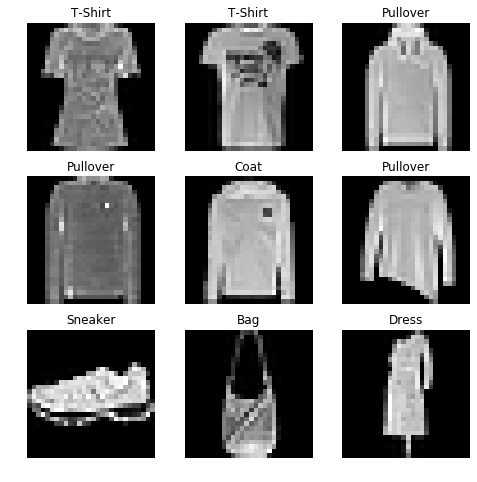

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

用DataLoaders准备训练数据
=================================================
`DataLoader` 提供了一些训练模型时的常用功能，例如每次读取一小批训练样本，
每次循环读取数据集时重新洗牌，用Python的`multiprocessing`加快数据读取。
-   [torch.utils.data API](https://pytorch.org/docs/stable/data.html)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 6


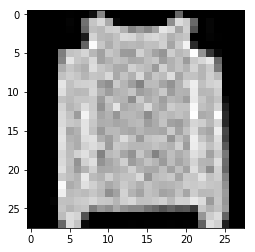

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# 展示图像和标签.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Transforms
=================================================
我们使用Transforms来对数据进行一些操作，使其适用于训练神经网络。
所有TorchVision数据集都有两个参数-用于修改特征的transform和用于修改标签的target transform。
[torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)提供了常用转换。
Fashion-MNIST数据集图片是PIL图像格式，标签是int整数。
我们需要将特征转化为张量，并将标签变为 one-hot 编码张量。

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

ToTensor()
==========

[ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor)
将PIL图像或ndarray转换为Float类型的张量，将图像的像素亮度值映射到区间[0, 1]

Lambda Transforms
=================
Lambda Transform调用任何用户定义的lambda函数。
我们定义一个函数将整数标签转换成one-hot编码张量。它首先创建一个大小为10的零张量，再调用
[scatter\_](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html)
在标签y的位置上分配`value=1`。


In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

组合Transforms
=================

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.449, 0.425, 0.392], std=[0.270, 0.267, 0.279])
])

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transforms
)